# TEXT MINING - WORKSPACE CONFUSION ANALYSIS

* Script developed using: R version 3.4.0 (2017-04-21)

* Platform: x86_64-w64-mingw32/x64 (64-bit)

* IBM - May 2018 (isabelad@br.ibm.com)

This notebook uses SVM classification and word cloud to support workspaces confusion analysis of sample questions to be used to create intentions for Watson Assistant (formely Watson Conversation). It gives a hint of subjects in different workspaces that can generate confusion when it comes to the router workspace classification.

In [53]:
#Libraries

library('dplyr') #data manipulation (filter, group, sort)
library('tidyr') #data tidying
library('ggplot2') #creating graphics
library('tm') #text mining
library('textstem') #stem and lemmatize text
library('ptstem') #stemming algorithms for the Portuguese Language
library('SnowballC') #text stemming
library('stringr') #string manipulation
library('wordcloud') # word-cloud generator
library('RColorBrewer') #color palettes
library('e1071') #support vector machine classification

Warning message:
"package 'e1071' was built under R version 3.4.4"

In [22]:
#Parameters

dir_file <- 'C:/Users/IsabelaDellaliberaPi/Box Sync/Backup Isa/CBDS/SANTANDER/Sara 2.0/Base Conhecimento/Cluster Workspaces/Workspaces'
base_file <- 'Teste_Clusterizacao_v5.csv'
token_file <- 'token.txt'
final_file <- 'cluster_workspaces_v5.csv'
model_file <- 'model_workspace.rda'
ngram <- 1
sparsity <- 0.995

## SECTION 1: Load and clean data

In [62]:
setwd(dir_file)
df <- read.csv(file = base_file, header = TRUE, sep = ";", dec = ".", stringsAsFactors = FALSE)
df <- cbind(df, ID=row.names(df))
df <- df[,-4:-5]
head(df, 5)

Canonica,Intencao,GRUPO,ID
Como consultar os valores atualizados de uma Tarifa?,Tarifa_PFePJ_Consultar_Valor_TarifaAtualizada,Tar,1
Como cadastrar isenção de tarifa para Pessoa Jurídica?,Tarifa_PacoteServico_PJ_Cadastrar_Isencao,Tar,2
Quais são os Pacotes de Serviços para Conta Corrente?,Tarifa_PacoteServico_PFePJ_Saber_PacoteServico_Segmentos,Tar,3
Como consultar o valor da tarifa de Adiantamento a Depositante no TFC?,Tarifa_Manutencao_PFePJ_Consultar_Valor_AdiantamentoDepositante,Tar,4
Qual o período para manter cópia dos documentos durante o processo em caso de cédulas suspeitas?,ContaCorrente_Movimentacao_PFePJ_Saber_Prazo_ManterDocumento_CedulaAutenticidadeDuvidosa_RecebidaCaixa,CC,5


In [63]:
#We are interested in the column containing the questions samples (e.j.:Canonica)
df <- df[!duplicated(df$Canonica),]
df_original <- df

In [64]:
#Function for text normalization

normalize_str <- function(s) {
  s <- iconv(s, to='ASCII//TRANSLIT')
  #s <- iconv(s, 'UTF-8', 'ASCII')
  s <- tolower(s)
  s <- gsub('/',' ', s)
  s<- removePunctuation(s)
  s <- removeNumbers(s)
    

#Dictionary with some important business specific terms to replace, mainly terms with less than 2 characters
###
  s <- gsub(' pj ',' pessoa juridica ', s)
  s <- gsub(' pf ',' pessoa fisica ', s)
  s <- gsub(' cc ',' conta corrente ', s)
  s <- gsub(' ag ',' agencia ', s)
  s <- gsub(' caps ',' capitalizacao ', s)
  s <- gsub(' cap ',' capitalizacao ', s)
  s <- gsub(' ib ',' internet banking ', s)
  s <- gsub(' ly ',' renly ', s)
  s <- gsub(' oy ',' renoy ', s)
  s <- gsub(' on line ',' online ', s)
  s <- gsub(' conta poupanca ',' contapoupanca ', s)
  s <- gsub(' conta max ',' contamax ', s)
  s <- gsub(' fundos ',' fundo ', s)
  s <- gsub(' di ',' cdi ', s)
  s <- gsub(' investimentos ',' investimento ', s)
  s <- gsub(' rendimentos ',' rendimento ', s)
  s <- gsub(' ir ',' imposto de renda ', s)
###  

    
  s <- chartr('ç', 'c', s)
  s <- gsub('\\b\\w{1,2}\\b','', s)
  s <- removeWords(s, stopwords('portuguese'))
  s <- gsub('\\\n','', s)
  s <- gsub('\\ +',' ', s)
}

In [65]:
df$Canonica <- normalize_str(df$Canonica)
corpus <- normalize_str(df$Canonica)
corpus <- ptstem(corpus, algorithm = "hunspell", complete = FALSE) #Stemming Algorithm for Portuguese
wc_corpus <- VCorpus(VectorSource(corpus), readerControl = list(language = "pt-BR"))

## SECTION 2: Create Term-Document Matrix for Text Mining

In [66]:
#Function for Tokenization

NgramTokenizer <- function(x){
  unlist(lapply(ngrams(words(x), c(1:ngram)), paste, collapse = ' '), use.names = FALSE)
  }


ndocs <- length(corpus)
MinTermFreq <- ndocs * 0.01 # ignore extremely rare words i.e. terms that appear in less then 1% of the documents
MaxTermFreq <- ndocs * .8 # ignore overly common words i.e. terms that appear in more than 80% of the documents


#Function to create the Document Term Matrix (dtm) by term frequency (tf-idf)

dtm <- TermDocumentMatrix(wc_corpus, 
                          control = list( weighting = function(x) weightTfIdf(x, normalize=FALSE),
                                          tokenize = NgramTokenizer,
                                          minWordLength = 2,
                                          bounds = list(global = c(MinTermFreq, MaxTermFreq)))
)
                              

In [67]:
dtm <- removeSparseTerms(dtm, sparsity)


#Matrix with tokens to build the word cloud 
mtx <- dtm
mtx <- as.matrix(mtx)

#Matrix with each line representing one document and tokens in columns
dtm <- t(dtm)
dtm <- as.matrix(dtm)
# normalizing lines
norm_vec <- function(x) sqrt(sum(x^2))
norms <- apply(dtm, 1, norm_vec)
dtm <- dtm/norms
    
head(dtm, 5)

,aberturar,agenciar,alterar,antecipacao,antecipar,atender,automatico,bancar,bloquear,bndes,...,tipo,tirar,titular,usar,utilizar,valor,vencer,ver,verificar,vidar
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0000000,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0000000,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0000000,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.5314126,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0000000,0,0,0,0


## Section 3: Wordcloud

In [68]:
v <- sort(rowSums(mtx),decreasing=TRUE)
d <- data.frame(word = names(v),freq=v)
head(d, 10)

,word,freq
qual,qual,5229.370
contar,contar,5198.051
cliente,cliente,5138.841
cartao,cartao,4745.320
ceder,ceder,4719.650
creditar,creditar,4541.568
poder,poder,4373.314
checar,checar,3781.845
pessoa,pessoa,3627.599
formar,formar,3434.431


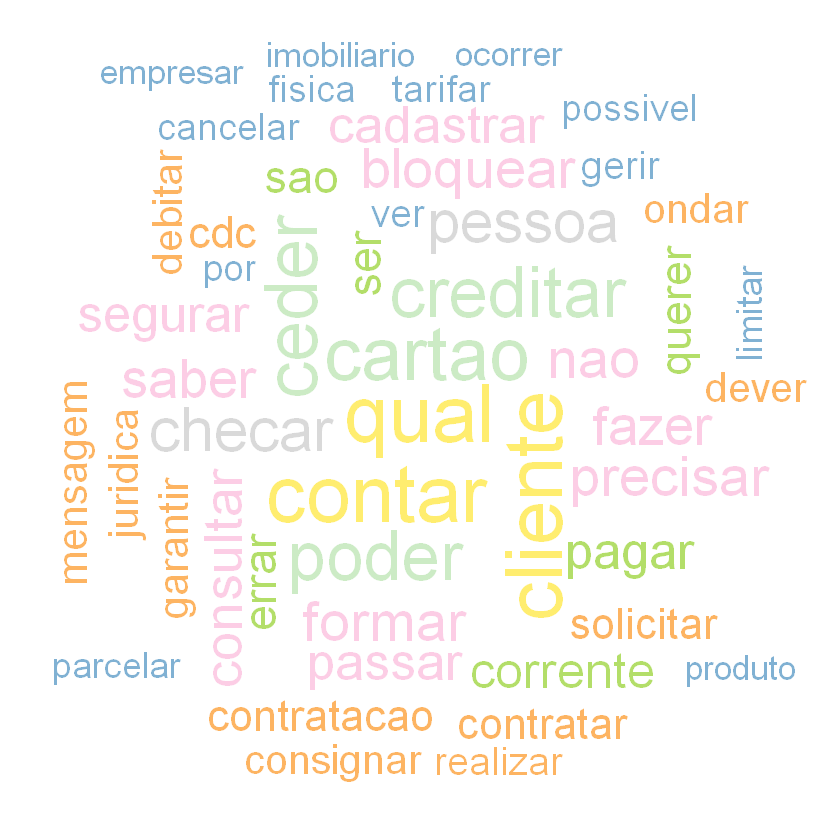

In [69]:
set.seed(1234)
wordcloud(words = d$word, freq = d$freq, min.freq = 1,
          max.words=50, random.order=FALSE, rot.per=0.35, 
          colors=brewer.pal(12, "Set3"))

## Section 4: Clustering using SVM considering  product grups

    * We will use this column "GRUPO" to train the dataset using 70% data. 
    
    * The rest will be classified and get the accuracy and we'll try to identify which products are conflicting the most.


In [70]:
# preparing data and removing duplicated rows
X_RF <- dtm
X_RF <- cbind.data.frame(GRUPO=df$GRUPO,X_RF)
X_RF <- cbind.data.frame(Canonica=df$Canonica,X_RF)
X_RF <- na.exclude(X_RF)
X_RF <- na.omit(X_RF)

In [71]:
#cross-validation(70/30)
train_X <- sample_frac(X_RF, 0.7)
ind_train <- rownames(train_X)%>%as.numeric()
test_X <- X_RF[-ind_train,]
test_y <- test_X$GRUPO
#levels(test_X$GRUPO) <- unique(X_RF$GRUPO)
test_y <- as.matrix(test_y) %>% as.data.frame()
colnames(test_y) <- 'GRUPO'
test_canonica <- test_X$Canonica
test_canonica  <- as.matrix(test_canonica) %>% as.data.frame()
colnames(test_canonica) <- 'Canonica'
test_X <- test_X[,-1:-2]
train_X <- train_X[, -1]

In [72]:
#training model and calculating accuracy
SVM_model <- svm(GRUPO ~ ., data = train_X, na.action =na.omit, scale = TRUE)
SVM_result <- predict(SVM_model, test_X)
SVM_result <- as.matrix(SVM_result) %>% as.data.frame()
colnames(SVM_result) <- 'CLUSTER'
  
acc_svm <- which(test_y==SVM_result)%>%length()/nrow(test_y)
print(paste('Acurácia SVM', acc_svm, sep = ' = '))

[1] "Acurácia SVM = 0.786242925555072"


In [73]:
test_X<- cbind.data.frame(GRUPO=as.vector(test_y),test_X)
test_X<- cbind.data.frame(CLUSTER=as.vector(SVM_result),test_X)
test_X<- cbind.data.frame(Canonica=as.vector(test_canonica),test_X)

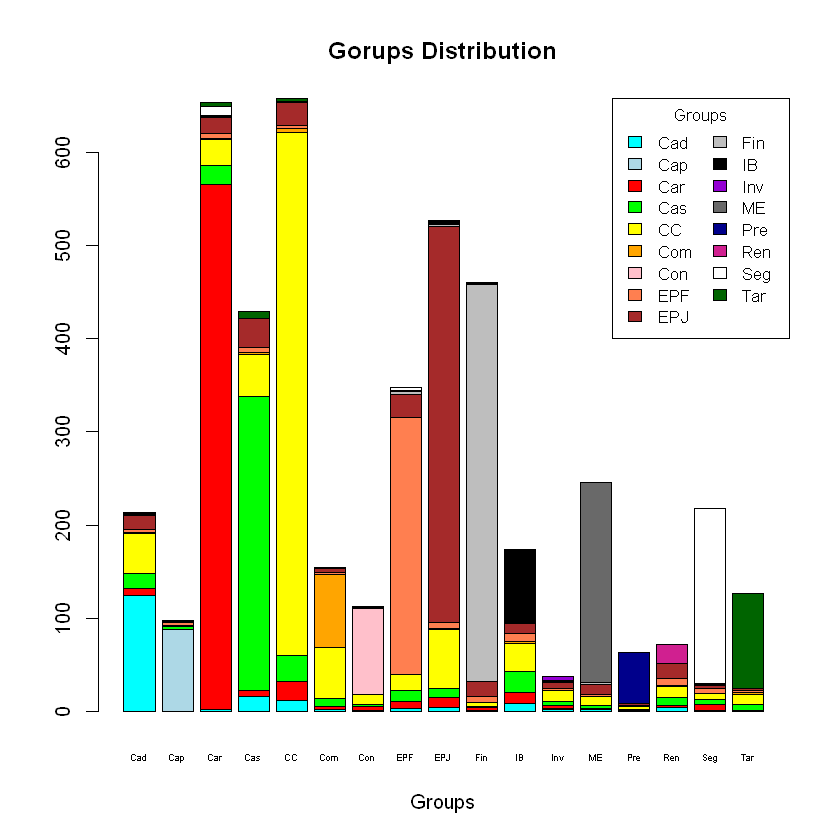

In [88]:
#create the bar graphic to comparison of workspace misclassification
graph <- table(test_X$CLUSTER, test_X$GRUPO)
barplot(graph, main="Gorups Distribution", cex.names=0.45,
        col = c("cyan", "lightblue","red", "green", "yellow", "orange", "pink", 
                "coral", "brown","grey", "black", "darkviolet",
                "dimgrey", "darkblue","violetred", "white", "darkgreen"), xlab="Groups") 
legend("topright", legend = rownames(graph), title="Groups",
       fill=c("cyan", "lightblue","red", "green", "yellow", "orange", "pink", 
                "coral", "brown","grey", "black", "darkviolet",
                "dimgrey", "darkblue","violetred", "white", "darkgreen"), ncol = 2, cex = 0.85)

In [59]:
final_X <- test_X[, 1:3]
final_X <- merge(final_X, df, by = 'Canonica')
final_X <- final_X[,-1]
final_X <- merge(final_X, df_original, by = 'ID')
final_X <- final_X[,-5]
final_X <- final_X[,-8:-11]

head(final_X, 3)

ID,CLUSTER,GRUPO.x,Intencao.x,SUBGRUPO.x,GRUPO_SUBGRUPO.x,Canonica
1000,EmprestimosPJ,Cadastro,ContaCorrente_Cadastro_PFePJ_Imprimir_FichaCadastral,Cadastro,ContaCorrente_Cadastro,Posso imprimir ficha cadastral vencida?
10001,Financiamentos,Financiamentos,Financiamentos_CDC_PF_Saber_Regra_Substituicao_MaquinasEquipamentos,CDC,Financiamentos_CDC,Cliente quer trocar sua máquina do contrato de CDC
10003,Financiamentos,Financiamentos,Financiamentos_CDC_PF_Saber_Bens_Permitidos,CDC,Financiamentos_CDC,Quais os bens financiáves no CDC?


In [58]:
#Export Final Model
write.csv2(x = final_X, file = final_file, row.names = FALSE)

Final observations:

* You can get to the conclusion that groups "Cap" and "Pre" are the most homogeneous (once almost everything was classified correctly inside those groups). For the rest, we could try to:

    1) identify if there are any specific subgroups that are being misclassified and understand why that is happening (maybe try to work on the examples dataset to make them better).
    
    2) try to unify groups that are mixed to get a better classification assertiveness on the router workspace.